In [1]:
# https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/
import pandas as pd
import numpy as np
from concat_stations import concat_files
import data_prep
from rf_optimize import evaluate
from scipy import stats
import matplotlib.pyplot as plt

import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import RandomizedSearchCV

In [3]:
full_data = concat_files() # Join all station data
full_data = pd.get_dummies(full_data) # Turn weekday into 1-hot encoding

In [5]:
# Fill in missing NaNs with median of columns
# nan_cols = [i for i in full_data.columns if full_data[i].isnull().any()] # Find all cols with NaN values
# for col in nan_cols:
#     full_data[col].fillna((full_data[col].median()), inplace=True) 

for i in full_data.columns:
    full_data = full_data[full_data[i].notna()]

In [4]:
feature_cols = list(full_data.drop('bikes', axis = 1).columns)

y = np.array(full_data['bikes']) # array for target variable
X = full_data[feature_cols] # Features
X = np.array(X) # Turn into numpy array

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)


In [6]:
"""
Now train the model
"""

# Instantiate model with optimised hyperparamters decision trees
rf = RandomForestRegressor(n_estimators = 400, min_samples_split = 2, min_samples_leaf = 1, 
max_features = 'sqrt', max_depth = None, bootstrap = False)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400)

[0.03644309 0.03845342 0.04803369 0.03407802 0.02720865 0.
 0.         0.01621154 0.02218683 0.02331759 0.00408983 0.01260358
 0.00965978 0.01037234 0.01826647 0.01708386 0.02110317 0.
 0.27966413 0.05050172 0.13215352 0.05423602 0.1283183  0.00218281
 0.00175868 0.00228933 0.00216512 0.00330794 0.00184492 0.00246564]


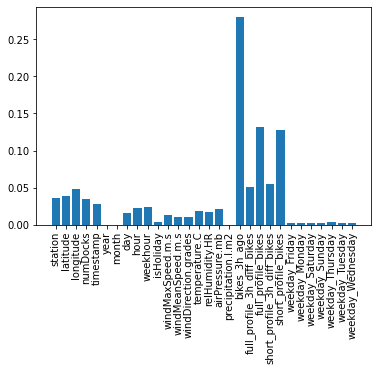

'\nUse  Recursive Feature Selection (RFE) to select features\nRFE works by creating predictive models, weighting features, and pruning those with the smallest weights, then repeating the process until a desired number of features are left.\n\nThe example below uses RFE with a random forest predictive model and sets the desired number of input features to 4.\n'

In [7]:
# show importance scores
print(rf.feature_importances_)
# plot importance scores
names = full_data.columns.values[0:-1]
ticks = [i for i in range(len(names))]
fig = plt.bar(ticks, rf.feature_importances_)
plt.xticks(ticks, feature_cols, rotation='vertical')
plt.show()

"""
Use  Recursive Feature Selection (RFE) to select features
RFE works by creating predictive models, weighting features, and pruning those with the smallest weights, then repeating the process until a desired number of features are left.

The example below uses RFE with a random forest predictive model and sets the desired number of input features to 4.
"""


Selected Features:
longitude
timestamp
bikes_3h_ago
full_profile_3h_diff_bikes
full_profile_bikes
short_profile_3h_diff_bikes
short_profile_bikes


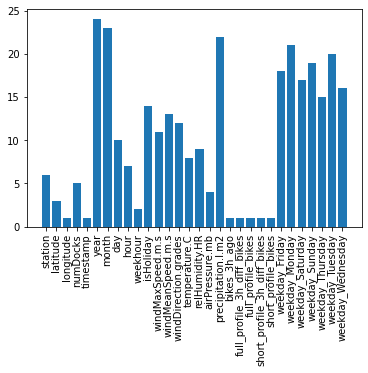

In [13]:
from sklearn.feature_selection import RFE

def get_important_features(X,y, names):
    """
    Prints the names of the 4 selected features.
    Results match features that showed a high importance in the previous section.
    Bar graph is also created showing the feature selection rank (smaller is better) for each input feature.
    """

    # names = feature_cols
    # perform feature selection
    rfe = RFE(RandomForestRegressor(n_estimators = 400, min_samples_split = 2, min_samples_leaf = 1, 
    max_features = 'sqrt', max_depth = None, bootstrap = False), n_features_to_select=7)
    fit = rfe.fit(X, y)
    # report selected features
    selected_features = []
    print('Selected Features:')
    for i in range(len(fit.support_)):
        if fit.support_[i]:
            print(names[i])
            selected_features.append(names[i])
    # plot feature rank
    ticks = [i for i in range(len(names))]
    plt.bar(ticks, fit.ranking_)
    plt.xticks(ticks, names, rotation='vertical')
    plt.show()

    return selected_features

selected features = get_important_features(X,y,feature_cols)

In [29]:
# Now train a new model with the reduced datasets.
full_data = concat_files()

# data = {'bikes_3h_ago':full_data['bikes_3h_ago'], 
# 'full_profile_3h_diff_bikes':full_data['full_profile_3h_diff_bikes'], 'full_profile_bikes':full_data['full_profile_bikes'],
# 'short_profile_3h_diff_bikes': full_data['short_profile_3h_diff_bikes'],
# 'short_profile_bikes':full_data['short_profile_bikes'], 'airPressure.mb':full_data['airPressure.mb'], 
# 'timestamp':full_data['timestamp'], 'longitude' : full_data['longitude'], 'weekhour' : full_data['weekhour']}
# new_full_data = pd.DataFrame(data = data)

# Unsure whether to include windmaxspeed, airhumidity --> do not. Results in worse performance. 
for i in full_data.columns:
    full_data = full_data[full_data[i].notna()]
    
feature_cols = ['longitude', 'timestamp', 'bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes', 'short_profile_3h_diff_bikes', 'short_profile_bikes', 'airPressure.mb', 'weekhour', 'station', 'numDocks', 'hour', 'day', 'latitude', 'temperature.C']

y = np.array(full_data['bikes']) # array for target variable
X = full_data[feature_cols] # Features
X = np.array(X) # Turn into numpy array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state    = 42)


"""
Now train the model
"""

# Instantiate model with optimised hyperparamters decision trees
rf = RandomForestRegressor(n_estimators = 400, min_samples_split = 2, min_samples_leaf =        1, max_features = 'sqrt', max_depth = None, bootstrap = False)
# Train the model on training data
rf.fit(X_train, y_train)

"""
Evaluation
"""
y_pred = rf.predict(X_test) # Use the forest's predict method on the test data
print("mae {}".format(metrics.mean_absolute_error(y_test, y_pred)))
print("r2_error {}".format(metrics.r2_score(y_test, y_pred)))

mae 1.9843300469483567
r2_error 0.8128760782002433


In [8]:
# Save model performance
model_type = "Random Forest"
data = {"model_type": model_type, "outlier_detection" : "threshold:3.25", "features" : len(new_full_data[df_features[0:-1]]), "params": rf.get_params(), "mean_abs_err": metrics.mean_absolute_error(y_test, y_pred),
"mean_sqrd_err" : metrics.mean_squared_error(y_test, y_pred), "Root_MSE" : np.sqrt(metrics.mean_squared_error(y_test, y_pred)), "r2_error" : metrics.r2_score(y_test, y_pred)}

with open('output_metrics.txt', 'a') as file:
     file.write(json.dumps(data)) # use `json.loads` to do the reverse

In [6]:
# Do outlier deletion, just for the selected features

# List all the bikes and include the bikes because needed for outlier deletion
df_features = ['longitude', 'timestamp', 'bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes', 'short_profile_3h_diff_bikes', 'short_profile_bikes', 'airPressure.mb', 'weekhour', 'station', 'numDocks', 'hour', 'day', 'latitude', 'temperature.C' ,'bikes']

df = full_data[df_features]
print(df.shape)

z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3.25).all(axis=1)
new_full_data = df[filtered_entries]


y = np.array(new_full_data['bikes']) # array for target variable
X = new_full_data[df_features[0:-1]] # Features (discluding bikes)
X = np.array(X) # Turn into numpy array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state    = 42)

"""
Now train the model
"""

# Instantiate model with optimised hyperparamters decision trees
rf = RandomForestRegressor(n_estimators = 400, min_samples_split = 2, min_samples_leaf =        1, 
max_features = 'sqrt', max_depth = None, bootstrap = False)
# Train the model on training data
rf.fit(X_train, y_train)

"""
Evaluation
"""
y_pred = rf.predict(X_test) # Use the forest's predict method on the test data
print("mae {}".format(metrics.mean_absolute_error(y_test, y_pred)))
print("r2_error {}".format(metrics.r2_score(y_test, y_pred)))


(42600, 16)
mae 1.9565205074207783
r2_error 0.7874516963207209


In [137]:
# Now handle outliers (start again with laoding in the data)
# We should detect these visually, but we'll do stats for now

full_data = concat_files() # Join all station data

for i in full_data.columns:
    full_data = full_data[full_data[i].notna()]
full_data = pd.get_dummies(full_data) # Turn weekday into 1-hot encoding


In [138]:
# Precipitation results in too many outliers and all data goes (so missed out). Isholiday also skipped out --> takes away thousands of datapoints and there shouldn't be outliers there so skipped. weekhour left in, no data is removed. Same true for hour, day, timestamp, longitude, latuitude and station. Month and yearbv left out --> killsw the data. NumDocks removes about 3000 - left in to see what happens (BUT TRY REMOVING AS WELL). Bikes col takes away about 73 datapoints --> so not a problem. All w/ abs score less than 3.
data = {'bikes_3h_ago':full_data['bikes_3h_ago'], 
'full_profile_3h_diff_bikes':full_data['full_profile_3h_diff_bikes'], 'full_profile_bikes':full_data['full_profile_bikes'],
'short_profile_3h_diff_bikes': full_data['short_profile_3h_diff_bikes'],
'short_profile_bikes':full_data['short_profile_bikes'], 'airPressure.mb':full_data['airPressure.mb'], 'relHumidity.HR':full_data['relHumidity.HR'], 'temperature.C' : full_data['temperature.C'], 'windMeanSpeed.m.s':full_data['windMeanSpeed.m.s'], 'windMaxSpeed.m.s': full_data['windMaxSpeed.m.s'], 'weekhour':full_data['weekhour'], 'hour':full_data['hour'], 'day':full_data['day'], 'timestamp':full_data['timestamp'], 'numDocks':full_data['numDocks'], 'longitude' : full_data['longitude'], 'latitude' : full_data['latitude'], 'station':full_data['station'], 'bikes':full_data['bikes']}
df = pd.DataFrame(data = data)

print(df.shape)

threshold_list = [3.2, 3.5, 3.75, 4, 4.5, 6, 6.5, 7, 10]
errors = []
for threshold in threshold_list:

    z_scores = stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    new_full_data = df[filtered_entries]

    # print('----------')
    # print(full_data.shape)
    # print(abs_z_scores)

    # print(filtered_entries)
    new_full_data.shape
    feature_cols = list(new_full_data.drop('bikes', axis = 1).columns)

    y = np.array(new_full_data['bikes']) # array for target variable
    X = new_full_data[feature_cols] # Features
    X = np.array(X) # Turn into numpy array

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state    = 42)

    """
Now train the model
"""

    # Instantiate model with optimised hyperparamters decision trees
    rf = RandomForestRegressor(n_estimators = 400, min_samples_split = 2, min_samples_leaf =        1, 
    max_features = 'sqrt', max_depth = None, bootstrap = False)
    # Train the model on training data
    rf.fit(X_train, y_train)

    """
    Evaluation
    """
    y_pred = rf.predict(X_test) # Use the forest's predict method on the test data
    print("mae {}".format(metrics.mean_absolute_error(y_test, y_pred)))
    print("r2_error {}".format(metrics.r2_score(y_test, y_pred)))

    errors.append(metrics.mean_absolute_error(y_test, y_pred))

print(threshold_list)
print(errors)

rounded_errors = [ round(elem, 2) for elem in errors ]
print(threshold_list)
print(rounded_errors)

import matplotlib.pyplot as plt
plt.plot(threshold_list, rounded_errors, '-o')


(42600, 19)
mae 1.9822075815933509
r2_error 0.7807018500800561
mae 2.0217179551122193
r2_error 0.7829567417784582
mae 1.994723018147087
r2_error 0.790287795591411
mae 1.992259739022764
r2_error 0.7885480165673725
mae 2.002940828122039
r2_error 0.7942950217658711
mae 2.0475597703313255
r2_error 0.7996126307412686
mae 2.0330274668422534
r2_error 0.8009847156760125
mae 2.0368434414668544
r2_error 0.8006290311924587
mae 2.0187936619718307
r2_error 0.807839601912188
[3.2, 3.5, 3.75, 4, 4.5, 6, 6.5, 7, 10]
[1.9822075815933509, 2.0217179551122193, 1.994723018147087, 1.992259739022764, 2.002940828122039, 2.0475597703313255, 2.0330274668422534, 2.0368434414668544, 2.0187936619718307]


[3.2, 3.5, 3.75, 4, 4.5, 6, 6.5, 7, 10]
[1.98, 2.02, 1.99, 1.99, 2.0, 2.05, 2.03, 2.04, 2.02]


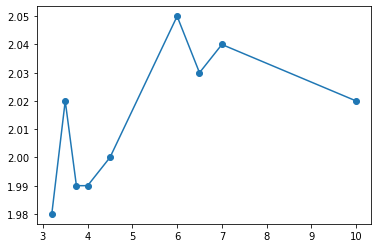

In [139]:
# removing outliers with percentiles
# We can come back ton this. The code providied for the tutorial didn't work so I have ignore the oiutlier section there.

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400)

In [118]:
"""
Evaluation
"""
y_pred = rf.predict(X_test) # Use the forest's predict method on the test data
print("mae {}".format(metrics.mean_absolute_error(y_test, y_pred)))
print("r2_error {}".format(metrics.r2_score(y_test, y_pred)))

mae 1.9946478032473736
r2_error 0.7897947640784814


In [ ]:
"""
z_score threshold = 3.75, mae = 1.9951, r2_error = 0.7901
"""

In [ ]:
"""
Now on to Binning
It is good for avoiding overfitting but it reduces performance. Making data more regularized. E.g. you bin values into 0-30 --> low, 31-70 --> medium etcetera.
I have skipped for now, because I just want to see better model performance. 
So it comes down to the overfitting-performance trade-off. 
"""

In [140]:
"""
Log Transform
Handle skewed data 
"""

'\nLog Transform\nHandle skewed data \n'

In [143]:
"""
Grouping columns - do for unstandaradised dataset. Ours is quite tidy I think.
"""
"""
Split method = good for strings. but we don't relaly have any string data so ignoring.
"""


In [149]:
"""
standardization - normalises 
"""
def standardize_data(data):
    for col in feature_cols:
        standardized = (data[col] - data[col].mean()) / data[col].std()
        data[col] = standardized
    return data

new_full_data = standardize_data(new_full_data)

 

In [152]:
y = np.array(new_full_data['bikes']) # array for target variable
X = new_full_data[feature_cols] # Features
X = np.array(X) # Turn into numpy array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state    = 42)

"""
Now train the model
"""

# Instantiate model with optimised hyperparamters decision trees
rf = RandomForestRegressor(n_estimators = 400, min_samples_split = 2, min_samples_leaf =        1, 
max_features = 'sqrt', max_depth = None, bootstrap = False)
# Train the model on training data
rf.fit(X_train, y_train)

"""
Evaluation
"""
y_pred = rf.predict(X_test) # Use the forest's predict method on the test data
print("mae {}".format(metrics.mean_absolute_error(y_test, y_pred)))
print("r2_error {}".format(metrics.r2_score(y_test, y_pred)))



mae 2.0206964788732393
r2_error 0.8077046510695548


In [ ]:
# Feature selection
data = concat_files()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import rfecv
from yellowbrick.datasets import load_credit


cv = StratifiedKFold(5)
visualizer = rfecv(RandomForestClassifier(), X=X, y=y, cv=cv, scoring='f1_weighted')